Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [111]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [112]:
## Mounting the google drive:

from google.colab import drive

drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This assignment uses a dataset of 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [91]:
# Defining the path for train and test images
## Updating the paths of the train and test dataset

data_dir_train = pathlib.Path("/content/drive/MyDrive/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/Test")

In [113]:
# Seeing number of images in Train & test data

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define parameters:

In [114]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [117]:
## Train Dataset
## Used seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory. Images resized to 180x180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size, image_size=(img_height,img_width), label_mode='categorical', seed=123,subset="training",
                                                               validation_split=0.2)



Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [118]:
## Validation Dataset
## Used seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory. Images resized to 180x180

val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32, image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [119]:
# Listed out all the classes of skin cancer and stored them in a list. 
# Class names can be found in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualizing the data
#### Creating a code to visualize one instance of all the nine classes available in the dataset

Found 2239 files belonging to 9 classes.


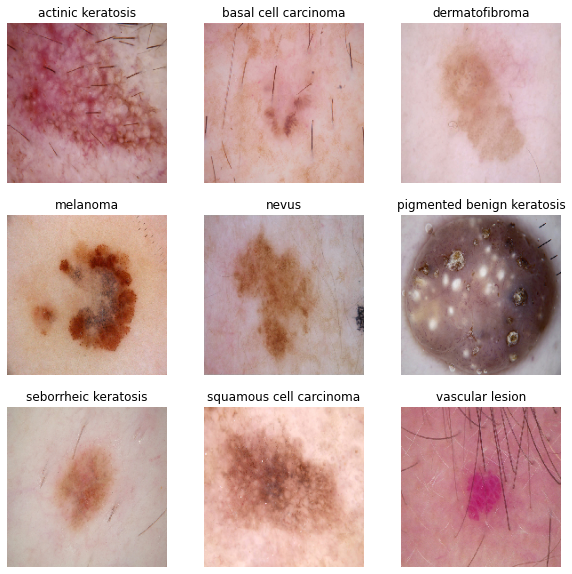

In [120]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

### Using training data to visualize

image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),  label_mode='categorical',seed=123)

classes = image_dataset.class_names
files_path = {}

for item in classes:
    files_path[item] = list(map(lambda x:str(data_dir_train)+'/'+item+'/'+x,os.listdir(str(data_dir_train)+'/'+item)))


plt.figure(figsize=(10,10))
index = 0
for item in class_names:
    path_list = files_path[item][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(item)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` : Keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` :Overlaps data preprocessing and model execution while training.

In [121]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. 
#### Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). (The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`)

In [122]:
## Adding sequential layers.  Not adding dropout latyers in first cut model

model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer (CL)
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second CL
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third CL
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Flattening Layer

model.add(layers.Flatten())

# Dense Layer
model.add(layers.Dense(128,activation='relu'))


#Dense Layer with softmax activation function to scale numbers into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [123]:
### Choosing Adam as optimiser and Categoriacl crossentropy as loss function
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [124]:
# View the summary of all layers
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 41, 41, 128)      

### Train the model

In [125]:
epochs = 20
history = model.fit(train_ds,  validation_data=val_ds,   epochs=epochs)

Epoch 1/20
56/56 [==============================] - 16s 91ms/step - loss: 2.0081 - accuracy: 0.2550 - val_loss: 1.7891 - val_accuracy: 0.3781
Epoch 2/20
56/56 [==============================] - 2s 40ms/step - loss: 1.6517 - accuracy: 0.3990 - val_loss: 1.5075 - val_accuracy: 0.4787
Epoch 3/20
56/56 [==============================] - 2s 38ms/step - loss: 1.4593 - accuracy: 0.4900 - val_loss: 1.4339 - val_accuracy: 0.5101
Epoch 4/20
56/56 [==============================] - 2s 39ms/step - loss: 1.4240 - accuracy: 0.5000 - val_loss: 1.4047 - val_accuracy: 0.5257
Epoch 5/20
56/56 [==============================] - 2s 39ms/step - loss: 1.3409 - accuracy: 0.5385 - val_loss: 1.3853 - val_accuracy: 0.5280
Epoch 6/20
56/56 [==============================] - 2s 39ms/step - loss: 1.2656 - accuracy: 0.5625 - val_loss: 1.4664 - val_accuracy: 0.4855
Epoch 7/20
56/56 [==============================] - 2s 39ms/step - loss: 1.1839 - accuracy: 0.5820 - val_loss: 1.4069 - val_accuracy: 0.4944
Epoch 8/20
5

### Visualizing training results

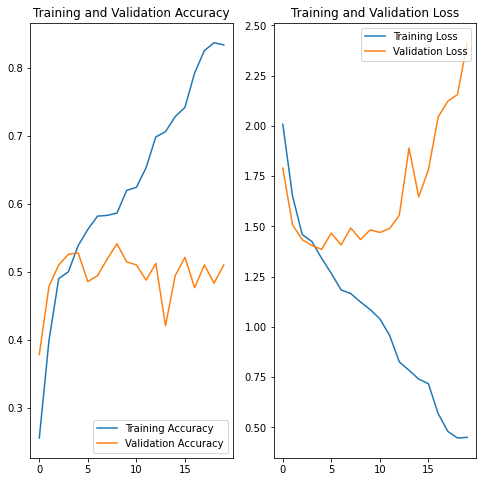

In [126]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings / Observations:

#### Validation accuracy is declining as compared to training accuracy
#### Validation loss is significantly higher than training loss
#### This shows that model is overfitting.  


# Findings

In [104]:
### Model is overfitting as observed in previous step.
### Let's add dropout layers to reduce overfitting

In [105]:
# Creating model with added dropout layers

### Create the model, compile and train the model with addition of dropout layers as a strategy to control overfitting


In [127]:
## Creating model again with dropout layers added (2 dropout layers with 50% & 25% fraction of input respectively)

model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer (CL)
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second CL
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third CL
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input
model.add(layers.Dropout(0.5))

#Flattening Layer

model.add(layers.Flatten())

# Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function to scale numbers into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))


### Compiling the model

In [128]:
## Compiling the model

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [129]:
# View the summary of all layers
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 41, 41, 128)      

### Training the model

In [130]:
# Training model for 20 epochs
epochs = 20
history = model.fit(train_ds,  validation_data=val_ds,   epochs=epochs)

Epoch 1/20
56/56 [==============================] - 3s 42ms/step - loss: 2.1165 - accuracy: 0.1998 - val_loss: 2.0105 - val_accuracy: 0.2125
Epoch 2/20
56/56 [==============================] - 2s 39ms/step - loss: 1.9047 - accuracy: 0.3080 - val_loss: 1.7259 - val_accuracy: 0.3937
Epoch 3/20
56/56 [==============================] - 2s 40ms/step - loss: 1.7166 - accuracy: 0.3616 - val_loss: 1.5753 - val_accuracy: 0.4385
Epoch 4/20
56/56 [==============================] - 2s 39ms/step - loss: 1.5610 - accuracy: 0.4425 - val_loss: 1.5065 - val_accuracy: 0.4631
Epoch 5/20
56/56 [==============================] - 2s 39ms/step - loss: 1.4589 - accuracy: 0.4927 - val_loss: 1.4732 - val_accuracy: 0.4899
Epoch 6/20
56/56 [==============================] - 2s 39ms/step - loss: 1.4143 - accuracy: 0.5045 - val_loss: 1.3894 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 2s 39ms/step - loss: 1.3549 - accuracy: 0.5296 - val_loss: 1.3809 - val_accuracy: 0.5302
Epoch 8/20
56

### Visualizing the results

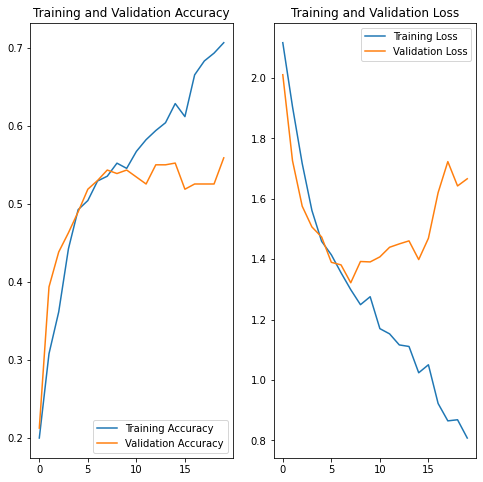

In [131]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Findings:

#### Gap between train & validation accuracy as well as loss has reduced to some extent 
#### Overfitting is taken care to some extent by adding two dropout layers

#### Checking the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [132]:
#### Visualize the distribution of data items for each class.

cList= []

for path in pathlib.Path(data_dir_train).iterdir():
        if path.is_dir():
          cList.append(len([item for item in os.listdir(path) if os.path.isfile(os.path.join(path, item))]))
    
dio = [name for name in os.listdir(data_dir_train) if os.path.isdir(os.path.join(data_dir_train, item))]
    
df = pd.DataFrame(list(zip(dio,cList)),columns =['Disease Class', 'Count of Images'])

df.sort_values(by = "Count of Images")

,Disease Class,Count of Images
3,seborrheic keratosis,77
8,dermatofibroma,95
4,actinic keratosis,114
0,vascular lesion,139
2,squamous cell carcinoma,181
1,nevus,357
7,basal cell carcinoma,376
6,melanoma,438
5,pigmented benign keratosis,462


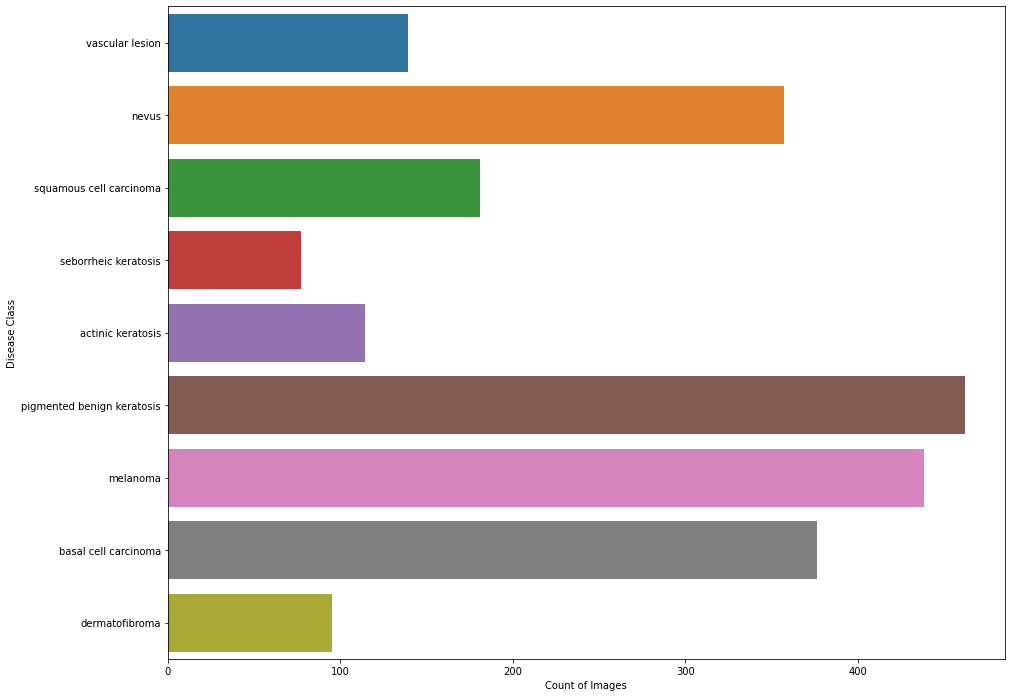

In [133]:
#### Visualize the class distribution

import seaborn as sns
plt.figure(figsize=(15, 12))
sns.barplot(x="Count of Images", y="Disease Class", data=df,
            label="Class")

# Findings:

-Seborrheic keratosis has least number of samples

-Nevus, melanoma & pigmented benign keratosis dominate the data in terms of number of samples.  They are disproportionately higher than other classes.


### Using Augmentor package to rectify the class imbalance. This will add more samples across all classes so that none of the classes have very few samples.

https://augmentor.readthedocs.io/en/master/

In [72]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [135]:
## Adding 500 samples per class

path_to_training_dataset="/content/drive/MyDrive/Train/"

import Augmentor


for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6CECE446D0>: 100%|██████████| 500/500 [00:17<00:00, 28.33 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6CDE713040>: 100%|██████████| 500/500 [00:17<00:00, 28.42 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6CECC92850>: 100%|██████████| 500/500 [00:20<00:00, 23.97 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6CECE58AC0>: 100%|██████████| 500/500 [01:25<00:00,  5.86 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7F6CECE40250>: 100%|██████████| 500/500 [01:16<00:00,  6.57 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6CED5A74C0>: 100%|██████████| 500/500 [00:17<00:00, 28.12 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6CECF05A90>: 100%|██████████| 500/500 [00:41<00:00, 12.04 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6CEC859CD0>: 100%|██████████| 500/500 [00:17<00:00, 28.18 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6CDE67AD30>: 100%|██████████| 500/500 [00:18<00:00, 26.97 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of disease types.

Taking a look at total count of augmented images.

In [136]:
image_count_train = 0
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [137]:
from glob import glob

path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/drive/MyDrive/Train/vascular lesion/output/vascular lesion_original_ISIC_0025707.jpg_c99adb7c-99da-4990-9f42-6541bf8008c5.jpg',
 '/content/drive/MyDrive/Train/vascular lesion/output/vascular lesion_original_ISIC_0031955.jpg_cafaa009-c1db-4838-932e-ca21420896e3.jpg',
 '/content/drive/MyDrive/Train/vascular lesion/output/vascular lesion_original_ISIC_0033254.jpg_3b2bf4b8-64ec-4de1-8421-d023acd9482c.jpg',
 '/content/drive/MyDrive/Train/vascular lesion/output/vascular lesion_original_ISIC_0031065.jpg_c620d552-e905-4dd4-af7a-1f4079165c26.jpg',
 '/content/drive/MyDrive/Train/vascular lesion/output/vascular lesion_original_ISIC_0025244.jpg_51261da6-10aa-401d-bd59-fa76d35a88e4.jpg',
 '/content/drive/MyDrive/Train/vascular lesion/output/vascular lesion_original_ISIC_0028188.jpg_855f934d-0187-4dda-a3d6-ff94f74d0913.jpg',
 '/content/drive/MyDrive/Train/vascular lesion/output/vascular lesion_original_ISIC_0028680.jpg_58b990af-99b5-4028-a301-533aa76efd93.jpg',
 '/content/drive/MyDrive/Tr

In [138]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [140]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [141]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df.append(df2)

In [142]:
new_df['Label'].value_counts()

vascular lesion               500
nevus                         500
squamous cell carcinoma       500
seborrheic keratosis          500
actinic keratosis             500
pigmented benign keratosis    500
melanoma                      500
basal cell carcinoma          500
dermatofibroma                500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### : Training the model on the data created using Augmentor

In [143]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating a training dataset

In [145]:
data_dir_train="/content/drive/MyDrive/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating a validation dataset

In [146]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Creating a model (With normalization)

In [147]:

model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer (CL)
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second CL
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third CL
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input
model.add(layers.Dropout(0.5))

#Flattening Layer

model.add(layers.Flatten())

# Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function to scale numbers into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))


#### Compiling the model (With apropriate optimizer and loss function)
#### We will use sparse_categorical_crossentropy & run with 30 epochs

In [151]:
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Train the model

In [152]:
epochs = 30

history = model.fit(train_ds,  validation_data=val_ds,   epochs=epochs)

Epoch 1/30
169/169 [==============================] - 31s 177ms/step - loss: 1.9367 - accuracy: 0.2528 - val_loss: 1.6866 - val_accuracy: 0.3430
Epoch 2/30
169/169 [==============================] - 31s 180ms/step - loss: 1.5574 - accuracy: 0.4075 - val_loss: 1.3480 - val_accuracy: 0.5122
Epoch 3/30
169/169 [==============================] - 30s 175ms/step - loss: 1.3905 - accuracy: 0.4794 - val_loss: 1.2548 - val_accuracy: 0.5249
Epoch 4/30
169/169 [==============================] - 31s 176ms/step - loss: 1.2567 - accuracy: 0.5341 - val_loss: 1.1972 - val_accuracy: 0.5561
Epoch 5/30
169/169 [==============================] - 30s 175ms/step - loss: 1.1277 - accuracy: 0.5868 - val_loss: 1.0525 - val_accuracy: 0.5798
Epoch 6/30
169/169 [==============================] - 31s 175ms/step - loss: 1.0503 - accuracy: 0.6213 - val_loss: 0.9826 - val_accuracy: 0.6303
Epoch 7/30
169/169 [==============================] - 31s 175ms/step - loss: 0.9606 - accuracy: 0.6447 - val_loss: 1.0404 - val_ac

#### Visualizing the model results

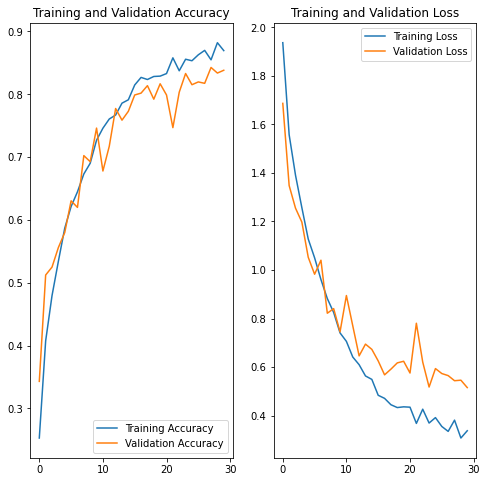

In [153]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####   Did you get rid of underfitting/overfitting? 
Yes.  Overfitting is now significantly reduced.  Gap between Train & Validation data loss as well as accuracy has lowered reasonably 
#### Did class rebalance help?
Yes.  The class rebalance has helped in tackling overfitting.



In [ ]:
## Observations:
# 1. Initial model did not have dropout layers
# 2. Overfitting extent was more & accuracy was less
# 3. Following two steps were taken, which resulted in getting rid of overfitting & improving accuracy:
#  a. Addition of dropout layers
#  b. Use of augmentor to increase sample data for all categories
